
# **Customers Segmentation based on their Credit Card usage behaviour**

Dataset for this notebook consists of credit card usage behavior of customers with 18 behavioral features. Segmentation of customers can be used to define marketing strategies.

In [ ]:
!pip install dataprep

     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 368kB 7.9MB/s 
     |████████████████████████████████| 10.1MB 8.2MB/s 
     |████████████████████████████████| 849kB 26.4MB/s 
     |████████████████████████████████| 1.4MB 47.0MB/s 
     |████████████████████████████████| 1.3MB 45.3MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 727kB 54.2MB/s 
     |████████████████████████████████| 112kB 53.6MB/s 
     |████████████████████████████████| 143kB 31.2MB/s 
     |████████████████████████████████| 296kB 40.6MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434675 sha256=c2bf4a62889bb98ad49db2c0a2285de27aca3617febd0994d42fb425cccfd713
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: wordcloud 1.5.0
    Unins

In [ ]:
import numpy as np
np.seterr(divide = "ignore")
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dataprep.eda import create_report

NumExpr defaulting to 2 threads.


### Get the Data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhytiatungga","key":"da716c2e6c42038335cc3590b004e335"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arjunbhasin2013/ccdata

  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 50.0MB/s]


In [ ]:
!ls

ccdata.zip  kaggle.json  sample_data


In [ ]:
import os, zipfile
zipRef = zipfile.ZipFile('ccdata.zip', 'r')
zipRef.extractall('files')
zipRef.close()

### Load the Data

In [ ]:
!ls /content/files

'CC GENERAL.csv'


In [ ]:
ccdata = pd.read_csv('/content/files/CC GENERAL.csv')

### Visualize the Data

DataPrep Report
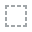
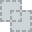
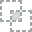
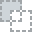
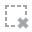
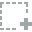
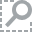
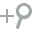
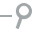
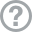
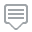
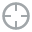
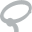
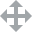
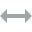
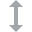
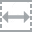
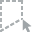
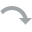
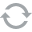
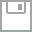
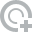
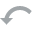
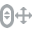
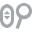
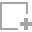
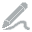
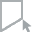
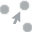
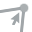
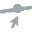

In [ ]:
create_report(ccdata)

In [ ]:
create_report(ccdata).save('./EDA')

Report has been saved to /content/./EDA.html!


### Data Preprocessing

In [ ]:
# ====== HANDLE MISSING VALUES
isNull = ccdata.isnull()
for feature in isNull.keys():
  if isNull[feature].value_counts()[False] == isNull.shape[0]:
    continue
  print(isNull[feature].value_counts())

False    8949
True        1
Name: CREDIT_LIMIT, dtype: int64
False    8637
True      313
Name: MINIMUM_PAYMENTS, dtype: int64


In [ ]:
# drop missing values from feature CREDIT_LIMIT
ccdata.dropna(subset=['CREDIT_LIMIT'], inplace=True)

In [ ]:
# fill missing values with mean from each feature
ccdata.fillna(ccdata.mean(), inplace=True)

In [ ]:
ccdata_ID = ccdata.CUST_ID
ccdata.drop(['CUST_ID'], axis=1, inplace=True)

In [ ]:
# ====== HANDLE SCALING & NORMALIZATION
# scaling the data

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = Normalizer()

scaler.fit(ccdata)
scaled_ccdata = scaler.transform(ccdata)
scaled_ccdata = pd.DataFrame(scaled_ccdata, columns=ccdata.columns)

In [ ]:
# normalize data
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=False)
norm_ccdata = pt.fit_transform(scaled_ccdata)
norm_ccdata = pd.DataFrame(norm_ccdata, columns=ccdata.columns)

In [ ]:
# ====== TRANSFORM DATA WITH PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_ccdata = pca.fit_transform(norm_ccdata)

### Create Model





In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

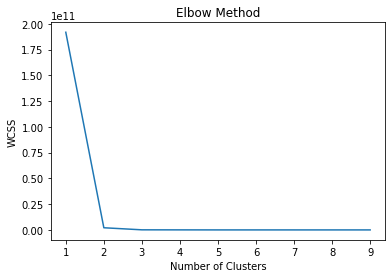

In [ ]:
kmeans_models = [KMeans(n_clusters=k, random_state=42).fit(norm_ccdata) for k in range(1,10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1,10), innertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

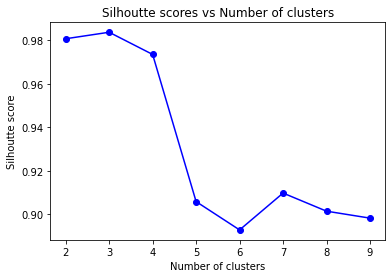

In [ ]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(norm_ccdata, model.labels_) for model in kmeans_models[1:]]
plt.plot(range(2, 10), silhoutte_scores, "bo-")
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [ ]:
def createModels(n_cluster):
  algorithms = []
  
  algorithms.append(('KMEANS', KMeans(n_clusters=n_cluster, random_state=42)))
  algorithms.append(('AHC', AgglomerativeClustering(n_clusters=n_cluster)))
  algorithms.append(('GMM', GaussianMixture(n_components=n_cluster, random_state=42)))
  # algorithms.append(('DBSCAN', DBSCAN(eps=0.1, min_samples=25, metric='euclidean', p=5)))
  return algorithms

### Evaluate Models with 2 Number of Clusters 

In [ ]:
algorithms = createModels(n_cluster=2)

clusterOut = pd.DataFrame(index=ccdata.index)
clusterOut['CUST_ID'] = ccdata_ID
for name, algo in algorithms:
  cluster = algo.fit_predict(norm_ccdata)
  clusterOut[name] = cluster
clusterOut.head(10)

CUST_ID  KMEANS  AHC  GMM
0  C10001       0    1    0
1  C10002       0    1    0
2  C10003       0    1    0
3  C10004       0    1    0
4  C10005       0    1    0
5  C10006       0    1    0
6  C10007       0    1    0
7  C10008       0    1    0
8  C10009       0    1    0
9  C10010       0    1    0

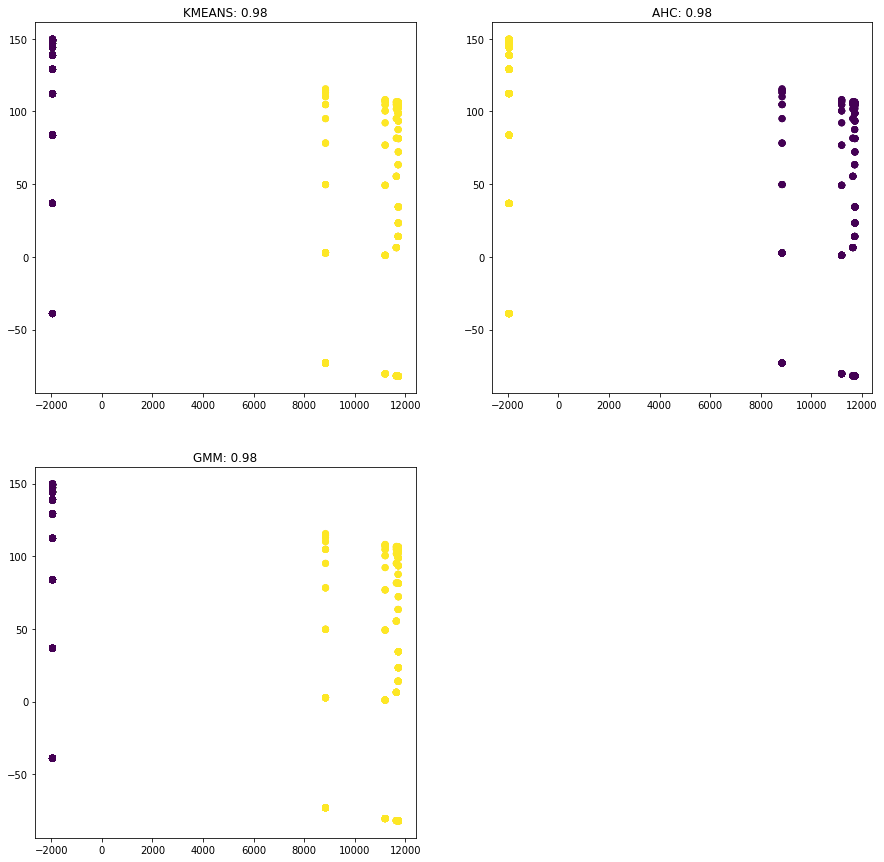

In [ ]:
silhouettes = []

plt.figure(figsize=(15,15))
for i, (name, algo) in zip(range(len(algorithms)), algorithms):
  cluster = clusterOut[name]
  silhouette = silhouette_score(norm_ccdata, cluster)
  silhouettes.append([name, silhouette])

  ax = plt.subplot(2,2,i+1)
  plt.scatter(pca_ccdata[:,0], pca_ccdata[:,1], c=cluster, alpha=.5)
  ax.set_title('{}: {:.2f}'.format(name, silhouette))


### Evaluate Models with 3 Number of Clusters

In [ ]:
algorithms = createModels(n_cluster=3)

clusterOut = pd.DataFrame(index=ccdata.index)
clusterOut['CUST_ID'] = ccdata_ID
for name, algo in algorithms:
  cluster = algo.fit_predict(norm_ccdata)
  clusterOut[name] = cluster
clusterOut.head(10)

CUST_ID  KMEANS  AHC  GMM
0  C10001       0    1    0
1  C10002       0    1    0
2  C10003       0    1    0
3  C10004       0    1    0
4  C10005       0    1    0
5  C10006       0    1    0
6  C10007       0    1    0
7  C10008       0    1    0
8  C10009       0    1    0
9  C10010       0    1    0

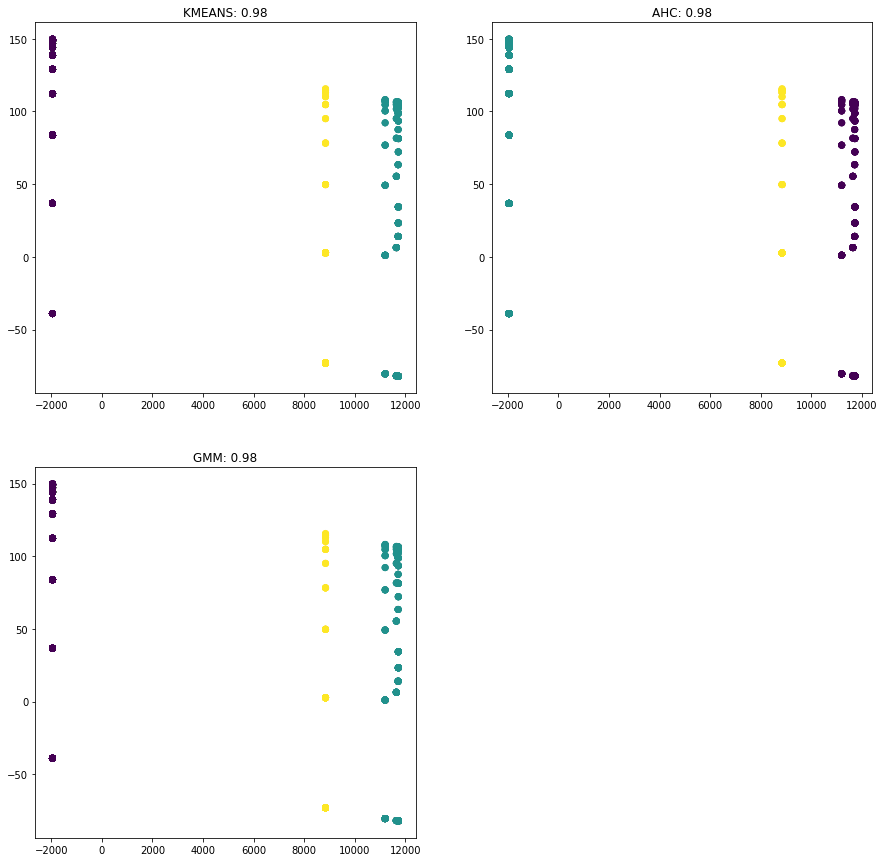

In [ ]:
silhouettes = []

plt.figure(figsize=(15,15))
for i, (name, algo) in zip(range(len(algorithms)), algorithms):
  cluster = clusterOut[name]
  silhouette = silhouette_score(norm_ccdata, cluster)
  silhouettes.append([name, silhouette])

  ax = plt.subplot(2,2,i+1)
  plt.scatter(pca_ccdata[:,0], pca_ccdata[:,1], c=cluster, alpha=.5)
  ax.set_title('{}: {:.2f}'.format(name, silhouette))